#Improved MUSIC for DOA estimation

## 1 Introduction
The basic MUSIC algorithm considers all the feature vectors in the noise subspace. However, if the number of array elements is greater than the number of sources, the dimensionality of the noise subspace could be excessively large. In addition, the accuracy of the MUSIC algorithm will be affected when there are errors regarding array amplitude and phase, or when the input signal is correlated.

The improved MUSIC algorithm can solve these problems effectively.
First of all, the array steering vector is appropriately split, and then the subspace algorithm is applied to the DOA estimation. On the other hand, low-dimensional noise subspace is used in order to reduce the computational complexity. In this way DOA and irrelevant signals can be properly estimated, and array errors can also be partially mitigated.

This improved version of MUSIC is introduced in *DOA estimation based on the improved MUSIC algorithm (Dai and Du)* and *DOA estimation based on the MUSIC algorithm (Tang)*.

##2 Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
def generate_data(M, N, d, wavelen, angles, freqs, var=0.01):
    thetas = np.array(angles) / 180 * np.pi
    w = np.array(freqs)*2*np.pi 
    D = np.size(thetas)
    A = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(thetas)).reshape((M, D)))
    S = 2 * np.exp(1j * (np.kron(w, np.arange(N)).reshape((D, N))))
    Noise = var * np.random.randn(M, N)
    X = np.dot(A, S) + Noise
    return X

In [3]:
def basic_musicDOA(X, M, d, wavelen, thetas, resscale="log"):
    D = np.size(thetas)
    # Make sure we have more receivers than input signals
    assert(M > D)
    # Peak search range (start degree, end degree, step)
    peak_search_range = np.arange(-90, 90, 0.5)
    # Center the output signal
    X_centered = (X.T - X.T.mean(axis=0)).T
    # Data covariance matrix: R = XX'
    R = np.dot(X_centered, X_centered.conj().T)
    # Eigen values decomposition of R
    eig_val, eig_vect = np.linalg.eig(R)
    # Find the smallest eigenvalues
    ids = np.abs(eig_val).argsort()[:(M-D)]  
    En = eig_vect[:,ids]
    # Noise subspace estimation: Ren = EnEn'
    Ren = np.dot(En, En.conj().T)
    # L = future size of Pmusic
    L = np.size(peak_search_range)
    # 
    a = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(peak_search_range * np.pi /180)).reshape(M, L))
    # Pmusic = a(peak_search_range)' * En * En' * a(peak_search_range)
    Pmusic = np.zeros(L)
    for i in range(L):
        Pmusic[i] = 1/abs(np.dot(a[:, i].conj().T, np.dot(Ren, a[:, i])))
    # Spatial spectrum function
    if resscale == "log":
        Pmusic = 10 * np.log10(Pmusic / np.max(Pmusic))    
    
    return Pmusic, peak_search_range

In [4]:
def improved_musicDOA(X, M, d, wavelen, thetas, L=0, resscale="log", corr="false", ee="false"):
    D = np.size(thetas)
    K=M-L
    # Make sure we have more receivers than input signals
    assert(M > D)
    # Peak search range (start degree, end degree, step)
    peak_search_range = np.arange(-90, 90, 0.5)
    # Center the output signal
    X_centered = (X.T - X.T.mean(axis=0)).T
    # Data covariance matrix: R = XX'
    R = np.dot(X_centered, X_centered.conj().T)
    # 
    if corr!="false":
      J = np.flip(np.eye(M), axis=1)
      R = R + np.dot(J, np.dot(R.conj(), J))

    # Eigen values decomposition of R
    eig_val, eig_vect = np.linalg.eig(R)
    # Find the smallest eigenvalues
    ids = np.abs(eig_val).argsort()[:(L+1)]  
    En = eig_vect[:,ids]
    # Noise subspace estimation: Ren = EnEn'
    Ren = np.dot(En, En.conj().T)
   
    # Size = future size of Pmusic
    Size = np.size(peak_search_range)

    m=np.arange(M)
    a=np.zeros((M,L+1))*1j
    # 
    #a = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(peak_search_range * np.pi /180)).reshape(M, L))
    # Pmusic = a(peak_search_range)' * En * En' * a(peak_search_range)
    Pmusic = np.zeros(Size)
    for i in range(Size):
        a[:K, 0] = np.exp(-1j*2*np.pi*d*np.sin(peak_search_range[i]*np.pi/180)/wavelen*m[:K])
        a[K:, 1:] = np.diag(np.exp(-1j*2*np.pi*d*np.sin(peak_search_range[i]*np.pi/180)/wavelen*m[K:]))
        Pmusic[i] = 1/abs(np.linalg.det(np.dot(a.conj().T, np.dot(Ren, a))))
    time=datetime.datetime.now()-starttime
    # Spatial spectrum function
    if resscale == "log":
        Pmusic = 10 * np.log10(Pmusic / np.max(Pmusic))    
    

    if ee!="false":
      x=peak_search_range[np.argmax(Pmusic)]
      a[:K, 0] = np.exp(-1j*2*np.pi*d*np.sin(x*np.pi/180)/wavelen*m[:K])
      a[K:, 1:] = np.diag(np.exp(-1j*2*np.pi*d*np.sin(x*np.pi/180)/wavelen*m[K:]))
      n, v = np.linalg.eig(np.dot(a.conj().T, np.dot(Ren, a)))
      error = v[:, np.argsort(np.absolute(n))[0]]
      error = error / error[0]
      return Pmusic, peak_search_range, error
    return Pmusic, peak_search_range

In [5]:
angles = np.array([20., 60.])
freqs = np.array([1/2, 1/3])
thetas = np.array(angles) / 180 * np.pi       
w = np.array(freqs)*2*np.pi     
N = 200                         
M = 10                         
D = np.size(thetas)                     
wavelen = 150                           
d = wavelen / 2                         
var = 0.01 

##3 Improved MUSIC Algorithm

The signal steering vector $a(\theta)$ plays a very important role in the MUSIC algorithm. In fact, the accuracy of the improved version depends on the correct preprocessing of $a(\theta)$.

Firstly, the array steering vector $a(\theta)$ is divided into $a_1(\theta)$ and $a_2(\theta)$: $a_1(\theta)$ consists of the first M-L elements of $a(\theta)$, and $a_2(\theta)$ consists of the last L elements of $a(\theta)$.

Then let's consider $a(\theta)$ written in the following form: 

$$ a(\theta) = 
\begin{bmatrix}
a_1,_0(\theta) & 0 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
a_1,_{K-1}(\theta) & 0 & \dots & 0 \\
0 & a_2,_0(\theta) & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & a_2,_{M-K-1}(\theta) \\
\end{bmatrix}
_{M\times(L+1)}
\begin{bmatrix}
1\\
\vdots \\
1\\
\end{bmatrix}
_{(L+1)\times1} = \tilde{a(\theta)}\Gamma 
$$

The destination of arrival is estimated by

$$
\hat\theta = \mathop{\arg\max}_{\theta}\frac{1}{det[\tilde{a}^H(\theta) U_N U_N^H \tilde{a}(\theta) ]       }.       
$$    
$$(K = M - L \geqslant P+1)$$

##4 Comparison 

###4.1 Execution speed
As introduced above, all the eigenvectors of the noise subspace are taken into account in MUSIC. When the number of microphones greatly exceeds the number of sources instead, choosing only some of the noise eigenvectors can lower the amount of computations.

Therefore, computing $U_N$ just requires the calculation of those eigenvectors corresponding to the L+1 smallest eigenvalues. This method reduces
the computational complexity. 

In [11]:
X = generate_data(M,N,d,wavelen,angles,freqs,var)


6950


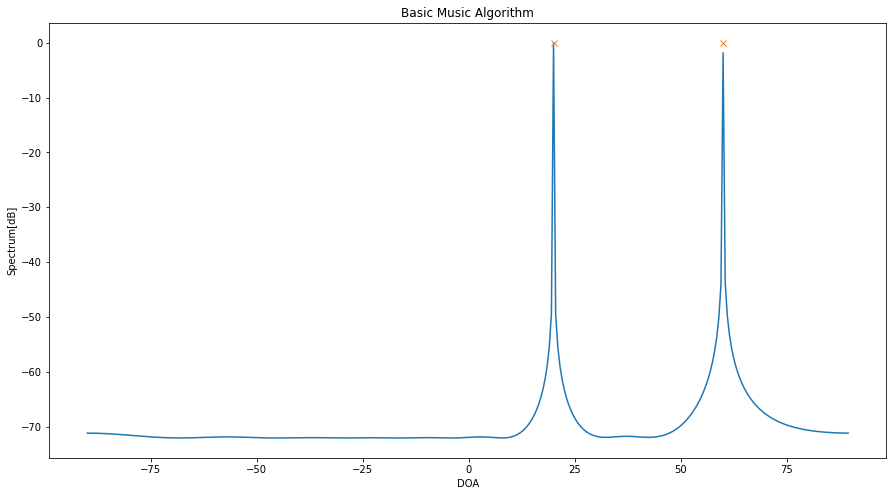

In [15]:
starttime = datetime.datetime.now()
Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen,thetas)
basictime=datetime.datetime.now()-starttime
plt.figure(figsize=(15,8))
plt.plot(peak_search_range, Pmusic)
plt.title("Basic Music Algorithm")
plt.plot(angles,np.zeros(angles.size),"x")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show
print(basictime.microseconds)

17984


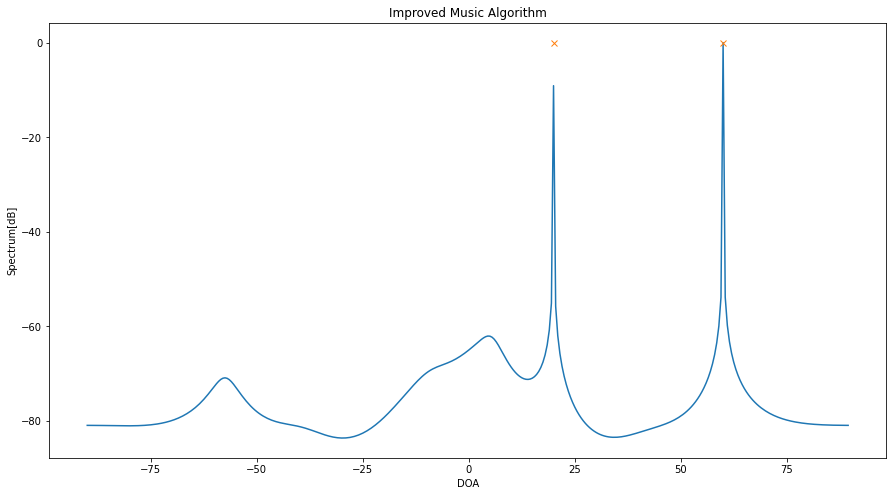

In [13]:
starttime = datetime.datetime.now()
Pmusic, peak_search_range= improved_musicDOA(X,M,d,wavelen,thetas,L=0)
improvedtime=datetime.datetime.now()-starttime
plt.figure(figsize=(15,8))
plt.plot(peak_search_range, Pmusic)
plt.title("Improved Music Algorithm")
plt.plot(angles,np.zeros(angles.size),"x")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show
print(improvedtime.microseconds)

###4.2 Coherent signals
The application of the basic MUSIC algorithm is limited to uncorrelated signals. When the signal source is a correlated one, the estimation accuracy of the algorithm could be reduced or even completely lost. The improved MUSIC algorithm can solve this issue by adding the following:

Make a transformation matrix
$ J = 
\begin{bmatrix}
0 & \dots & 1  \\
\vdots&\ddots &\vdots\\
1 &\dots & 0  \\
\end{bmatrix}
$.


Let $Y = JX^*$, where $X^*$ is the complex conjugate of $X$. Then the covariance of the data matrix $Y$ is
 $$R_y = E[YY^H]=JRX^*J .$$

Construct the new matrix $R$ from the sum of $R_x$ and $R_y$:

$$R = R_x + R_y = 𝐴𝑅_𝑠𝐴^𝐻+J[𝐴𝑅_𝑠𝐴^𝐻]J^*+2𝜎2𝐼  .$$

The matrices $R_x$, $R_y$ and $R$ share the same noise subspace.

In order to perform eigen-decomposition of $R$ and to obtain the eigenvalues and eigenvectors of $R$ according to the estimated number of signal sources, the noise subspace is separated, and then this new noise subspace is used in the construction of the spatial spectrum. In the end the estimated DOA is obtained by finding the peak value.

In [ ]:
a=np.array([40, 60, 80])
f=np.array([1/3, 1/4, 1/3]) * np.pi 
X = generate_data(M,N,d,wavelen,a,f,var)

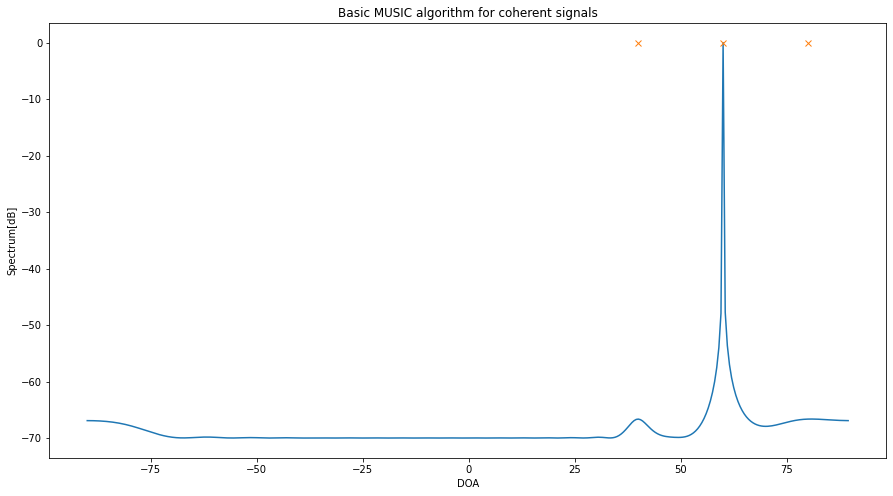

In [ ]:
plt.figure(figsize=(15,8))
Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen,thetas)
plt.plot(peak_search_range, Pmusic)
plt.plot(a,np.zeros(a.size),"x")
plt.title("Basic MUSIC algorithm for coherent signals")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show()

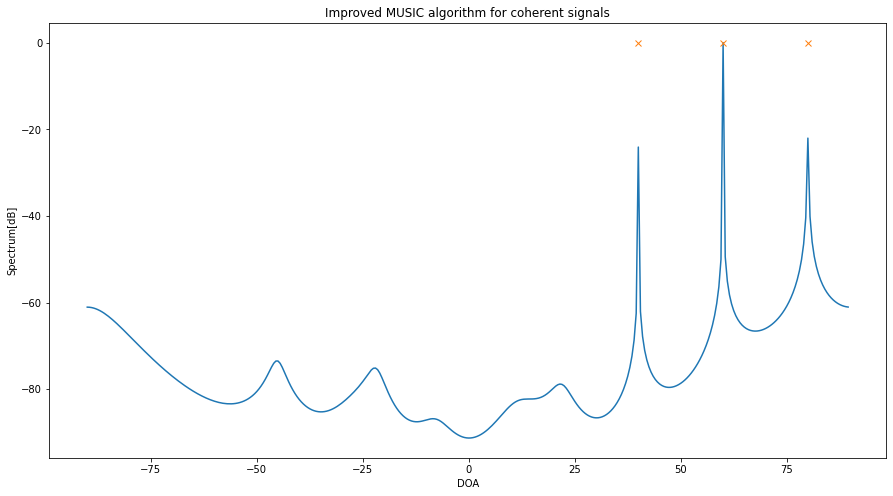

In [ ]:
plt.figure(figsize=(15,8))
Pmusic, peak_search_range= improved_musicDOA(X,M,d,wavelen,thetas,corr="true",L=7)
plt.plot(peak_search_range, Pmusic)
plt.plot(a,np.zeros(a.size),"x")
plt.title("Improved MUSIC algorithm for coherent signals")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show()

###4.3 The array amplitude-phase error estimation
When the last L elements in the steering vector are affected by array errors, the improved algorithm can still estimate the signal DOA, and can also estimate the corresponding array error.


$$ a'(\theta) = 
\begin{bmatrix}
a_1,_0(\theta) & 0 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
a_1,_{K-1}(\theta) & 0 & \dots & 0 \\
0 & a_2,_0(\theta) & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & a_2,_{M-K-1}(\theta) \\
\end{bmatrix}
_{M\times(L+1)}
\begin{bmatrix}
1\\
\vdots \\
G1\\
G2\\
\vdots\\
GL\\
\end{bmatrix}
_{(L+1)\times1} = \tilde{a'(\theta)}\Gamma '
$$

Let's assume the L errors to be $G_1,...,G_L$. Since $\Gamma' != 0$, it is still possible to perform the DOA estimation. The array error estimation can be obtained by computing the eigenvector of the smallest eigenvalue, and the first element of $\Gamma'$ is 1.

In [ ]:
X = generate_data(M,N,d,wavelen,angles,freqs,var)
L=4
phase_error = np.random.normal(0, np.pi/4, L)
amp_error = np.random.normal(1, 0.3, L)
X[-L:, :] = X[-L:, :] * np.tile(amp_error, (N, 1)).T * np.tile(np.exp(1j*phase_error), (N, 1)).T

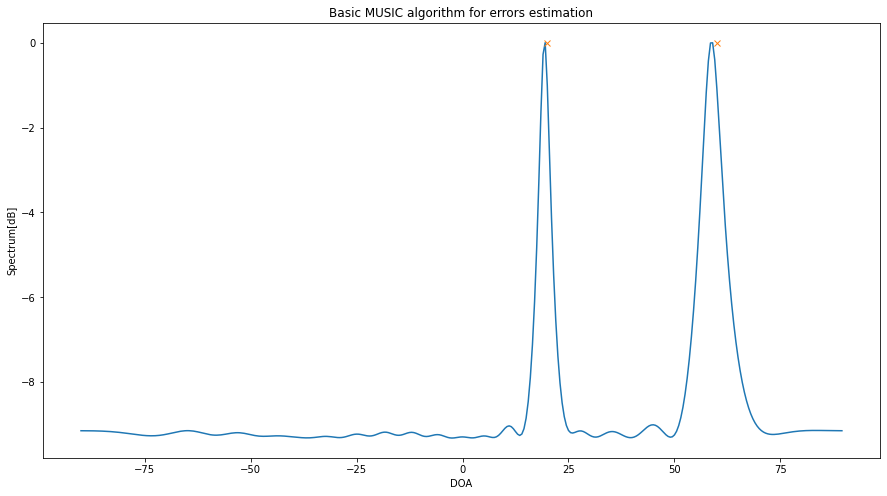

In [ ]:
plt.figure(figsize=(15,8))
Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen,thetas)
plt.plot(peak_search_range, Pmusic)
plt.plot(angles,np.zeros(angles.size),"x")
plt.title("Basic MUSIC algorithm for errors estimation")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show()

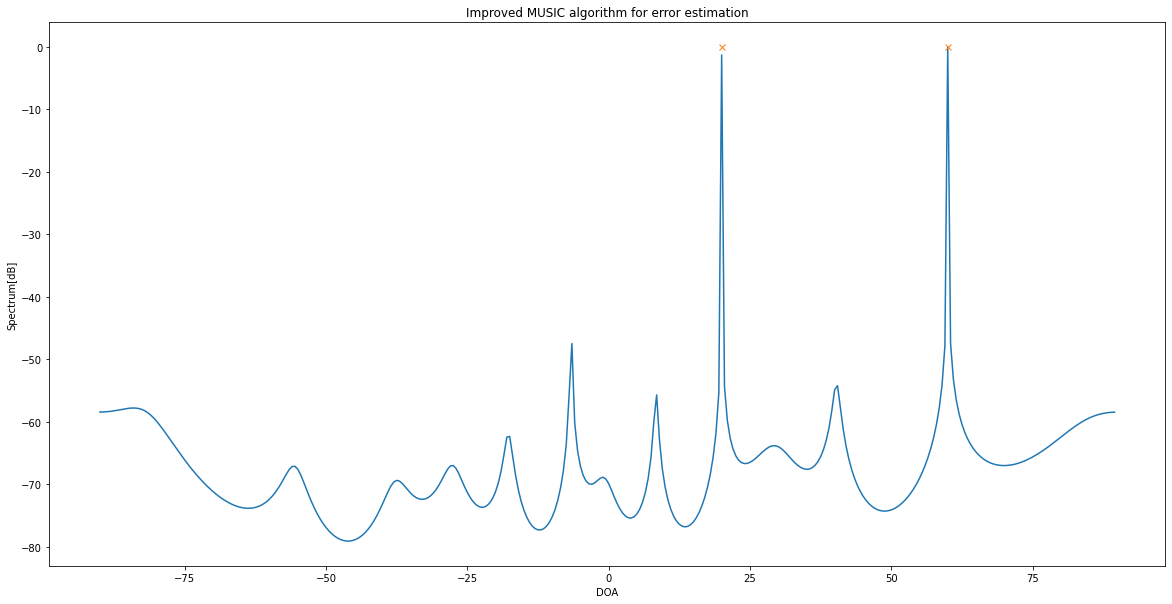

actual amplitude error:
1.5582
1.0034
0.9701
1.1533
estimated:
1.5646
1.0033
0.9711
1.1514

 actual phase error:
1.4992
0.3599
0.0507
0.7800
estimated:
1.4983
0.3603
0.0510
0.7792


In [ ]:
Pmusic, peak_search_range, error= improved_musicDOA(X,M,d,wavelen,thetas,L, ee="true")
plt.figure(figsize=(20,10))
plt.plot(peak_search_range, Pmusic)
plt.plot(angles,np.zeros(angles.size),"x")
plt.title("Improved MUSIC algorithm for error estimation")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show()


amp_error_estimation = np.absolute(error)
phase_error_estimation = np.angle(error)

print('actual amplitude error:')
for x in amp_error.tolist():print('%.4f' % x)

print('estimated:')
for x in amp_error_estimation.tolist()[1:]:print('%.4f' % x)

print('\n actual phase error:')
for x in phase_error.tolist():print('%.4f' % x)

print('estimated:')
for x in phase_error_estimation.tolist()[1:]:print('%.4f' % x)